# Enviroment Setting

In [ ]:
!curl https://colab.chainer.org/install | sh -


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0  25901      0 --:--:-- --:--:-- --:--:-- 25901
********************************************************************************
GPU is not enabled!
Open "Runtime" > "Change runtime type" and set "Hardware accelerator" to "GPU".
********************************************************************************


In [ ]:
!pip install cucim
!pip install scipy scikit-image cupy-cuda100

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.6 MB 24.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58.9 MB 1.1 MB/s 


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
#upload your kaggle token here
files.upload()

TypeError: ignored

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dhruvildave/amazon-bin-image-dataset

In [ ]:
!unzip -q /content/amazon-bin-image-dataset.zip

# Importing Libraries

In [ ]:
%matplotlib inline
import sqlite3
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import random
import PIL
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
import cupy as cp
import cucim
import json
from sklearn.decomposition import PCA
from skimage.feature import hog,blob_log
from keras.preprocessing.image import ImageDataGenerator
from scipy import signal
from sklearn.model_selection import cross_val_score

# Dataset Invistigation

In [ ]:
import json
import sqlite3
conn = sqlite3.connect("/content/metadata.sqlite")
meta_df = pd.read_sql_query("""
SELECT json_extract(data, '$.BIN_FCSKU_DATA') AS data,
    json_extract(data, '$.EXPECTED_QUANTITY') AS quantity,
    img_id AS img_id
FROM metadata
Where quantity < 5
""", conn)

In [ ]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28837 entries, 0 to 28836
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   data      28837 non-null  object
 1   quantity  28837 non-null  int64 
 2   img_id    28837 non-null  object
dtypes: int64(1), object(2)
memory usage: 676.0+ KB


In [ ]:
meta_df.isna().sum()

data        0
quantity    0
img_id      0
dtype: int64

In [ ]:
meta_df.isnull().sum()

data        0
quantity    0
img_id      0
dtype: int64

In [ ]:
meta_df["data"][0]

'{"B018240DGG":{"asin":"B018240DGG","height":{"unit":"IN","value":1.0999999988780003},"length":{"unit":"IN","value":17.99999998164},"name":"iPad Air 2 Case, Thankscase Rotating Leather Case Cover with Business Card Holder for Personalization or Company Logo, Build-in Wallet Pocket and Hand Strap Case for iPad Air 2. (Brown Leather)","normalizedName":"iPad Air 2 Case, Thankscase Rotating Leather Case Cover with Business Card Holder for Personalization or Company Logo, Build-in Wallet Pocket and Hand Strap Case for iPad Air 2. (Brown Leather)","quantity":3,"weight":{"unit":"pounds","value":0.5999999994968457},"width":{"unit":"IN","value":11.699999988066}}}'

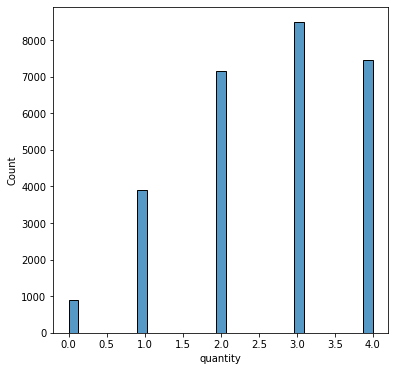

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
sns.histplot(meta_df.quantity)

# Creating The Dataset

In [ ]:
def sampling_k_elements(group, k=4000):
    if len(group) < k:
        return group
    return group.sample(k)

meta_df = meta_df.groupby('quantity').apply(sampling_k_elements).reset_index(drop=True)

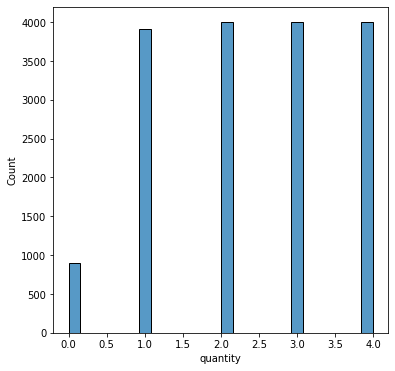

In [ ]:
plt.figure(figsize=(6,6))
sns.histplot(meta_df.quantity)

In [ ]:
%rm -r resized/
%mkdir resized/

invalidPaths=[]
for img_id in tqdm(meta_df.img_id):
  # to read Image in grayscale mode
  img = cv2.imread(f"/content/img/{img_id}.jpg", 0)
  if not (isinstance(img,type(None))):
    try:
      img = cv2.resize(img,(224,224), interpolation = cv2.INTER_AREA)
    except:
      #img = cv2.copyMakeBorder()
      print(img.shape)
      break
    cv2.imwrite(f"/content/resized/{img_id}.jpg",img)
  else:
    invalidPaths.append(f"/content/img/{img_id}.jpg")

100%|██████████| 16808/16808 [01:10<00:00, 238.64it/s]


In [ ]:
dataset = np.array([i.path for i in os.scandir("/content/resized")])

In [ ]:
Img_labels = []
for i in tqdm(dataset):
  img_ID = i.split('/')[-1].split('.')[0]
  Img_labels.append(meta_df[meta_df.img_id==img_ID].quantity.values[0])

100%|██████████| 16807/16807 [00:31<00:00, 540.25it/s]


# Split the Dataset into 70% train, 20%test and 10% validation

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(dataset, Img_labels, test_size=0.2, random_state=42,stratify=Img_labels)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size=0.1, random_state=42,stratify=train_labels)
# del dataset
# del Img_labels
# del images

# Define Custom Dataset class for the dataloader

In [ ]:
BATCH_SIZE = 128
import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
import torch.nn.functional as F

class dataset(Dataset):
  def __init__(self, feat_arr, label):
    self.feat_arr = feat_arr
    self.label = label
  def __getitem__(self, index):
    return torch.tensor(np.moveaxis(cv2.imread(self.feat_arr[index]),-1,0)).float(),torch.tensor((self.label[index]))
  def __len__(self):
    return len(self.feat_arr)

train_dataloader = DataLoader(dataset(train_features,train_labels),batch_size = BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(dataset(val_features,val_labels),batch_size = BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset(test_features,test_labels),batch_size = BATCH_SIZE, shuffle=True)

# Train The Model

In [ ]:
cuda = torch.cuda.is_available()
print("GPU:", cuda)

GPU: True


## Training Loop

In [ ]:
train_accu = []
train_losses = []
eval_losses=[]
eval_accu=[]

def train_model(model,epoch,train_dataloader,val_dataloader):
  print('\nEpoch : %d'%epoch)
   
  model.train()
 
  running_loss=0
  correct=0
  total=0
 
  for inputs,labels in tqdm(train_dataloader):
    if cuda:
      inputs,labels=inputs.cuda(),labels.cuda()
     
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
 
    running_loss += loss.item()
     
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
       
  train_loss=running_loss/len(train_dataloader)
  accu=correct/total
   
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Train Accuracy: %.3f'%(train_loss,accu),end=" | ")


  model.eval()
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for val_inputs,val_labels in val_dataloader:

      if cuda:
        val_inputs,val_labels = val_inputs.cuda(),val_labels.cuda()
       
      outputs=model(val_inputs)
 
      loss= loss_fn(outputs,val_labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += val_labels.size(0)
      correct += predicted.eq(val_labels).sum().item()
   
  val_loss=running_loss/len(val_dataloader)
  accu=correct/total
 
  eval_losses.append(val_loss)
  eval_accu.append(accu)
 
  print('Val Loss: %.3f | Validation Accuracy: %.3f'%(val_loss,accu))

## Testing Loop

In [ ]:
y_pred=[]
y_true=[]
def test_model(model,test_dataloader):
  model.eval()
  running_loss=0
  correct=0
  total=0
 
  with torch.no_grad():
    for test_inputs,test_labels in test_dataloader:

      if cuda:
        test_inputs,test_labels = test_inputs.cuda(),test_labels.cuda()
       
      outputs=model(test_inputs)
 
      loss= loss_fn(outputs,test_labels)
      running_loss+=loss.item()
       
      _, predicted = outputs.max(1)
      total += test_labels.size(0)
      correct += predicted.eq(test_labels).sum().item()
   
      test_loss=running_loss/len(test_dataloader)
      accu=correct/total
 
      y_pred.extend((torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()) # Save Prediction
      test_labels = test_labels.data.cpu().numpy()
      y_true.extend(test_labels) # Save Truth
 
  print('test Accuracy: %.3f'%(accu))

## Using ResNet34 with SGD --> 44.9% (Overfitted)

In [ ]:
from torchvision.models import resnet34
model = resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
 
LEARNING_RATE = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr= LEARNING_RATE,momentum=0.9)

if cuda: 
  model.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
EPOCHS=10
for epoch in range(1,EPOCHS+1): 
  train_model(model,epoch,train_dataloader,val_dataloader)


Epoch : 1


100%|██████████| 95/95 [01:11<00:00,  1.32it/s]


Train Loss: 1.381 | Train Accuracy: 0.349 | Val Loss: 1.279 | Validation Accuracy: 0.390

Epoch : 2


100%|██████████| 95/95 [01:05<00:00,  1.45it/s]


Train Loss: 1.114 | Train Accuracy: 0.497 | Val Loss: 1.162 | Validation Accuracy: 0.436

Epoch : 3


100%|██████████| 95/95 [01:05<00:00,  1.45it/s]


Train Loss: 0.975 | Train Accuracy: 0.585 | Val Loss: 1.146 | Validation Accuracy: 0.457

Epoch : 4


100%|██████████| 95/95 [01:05<00:00,  1.45it/s]


Train Loss: 0.836 | Train Accuracy: 0.667 | Val Loss: 1.148 | Validation Accuracy: 0.483

Epoch : 5


100%|██████████| 95/95 [01:05<00:00,  1.45it/s]


Train Loss: 0.668 | Train Accuracy: 0.766 | Val Loss: 1.174 | Validation Accuracy: 0.470

Epoch : 6


100%|██████████| 95/95 [01:05<00:00,  1.45it/s]


Train Loss: 0.472 | Train Accuracy: 0.870 | Val Loss: 1.280 | Validation Accuracy: 0.446

Epoch : 7


100%|██████████| 95/95 [01:05<00:00,  1.45it/s]


Train Loss: 0.277 | Train Accuracy: 0.949 | Val Loss: 1.448 | Validation Accuracy: 0.465

Epoch : 8


100%|██████████| 95/95 [01:05<00:00,  1.45it/s]


Train Loss: 0.138 | Train Accuracy: 0.989 | Val Loss: 1.592 | Validation Accuracy: 0.464

Epoch : 9


100%|██████████| 95/95 [01:05<00:00,  1.44it/s]


Train Loss: 0.066 | Train Accuracy: 0.998 | Val Loss: 1.675 | Validation Accuracy: 0.455

Epoch : 10


100%|██████████| 95/95 [01:05<00:00,  1.45it/s]


Train Loss: 0.035 | Train Accuracy: 0.999 | Val Loss: 1.839 | Validation Accuracy: 0.465


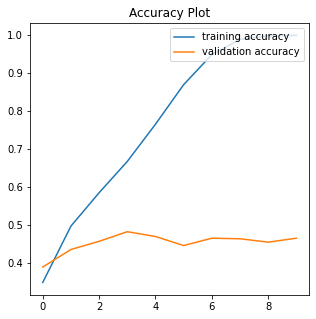

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Accuracy Plot")
plt.plot(train_accu,label='training accuracy')
plt.plot(eval_accu,label='validation accuracy')
plt.legend(loc='upper right')

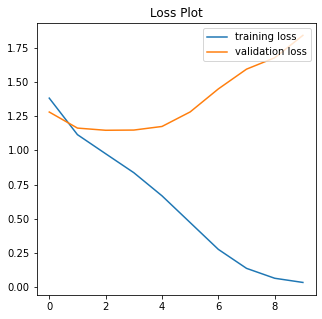

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Loss Plot")
plt.plot(train_losses,label='training loss')
plt.plot(eval_losses,label='validation loss')
plt.legend(loc='upper right')

In [ ]:
y_pred=[]
y_true=[]
test_model(model,test_dataloader)

test Accuracy: 0.449


## ResNet50 with SGD --> 43.7%

In [ ]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
 
LEARNING_RATE = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr= LEARNING_RATE,momentum=0.9)

if cuda: 
  model.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
EPOCHS=5
for epoch in range(1,EPOCHS+1): 
  train_model(model,epoch,train_dataloader,val_dataloader)


Epoch : 1


100%|██████████| 95/95 [02:05<00:00,  1.33s/it]


Train Loss: 1.376 | Train Accuracy: 0.342 | Val Loss: 1.244 | Validation Accuracy: 0.398

Epoch : 2


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 1.151 | Train Accuracy: 0.476 | Val Loss: 1.170 | Validation Accuracy: 0.455

Epoch : 3


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 1.041 | Train Accuracy: 0.535 | Val Loss: 1.128 | Validation Accuracy: 0.469

Epoch : 4


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 0.929 | Train Accuracy: 0.604 | Val Loss: 1.144 | Validation Accuracy: 0.478

Epoch : 5


100%|██████████| 95/95 [02:07<00:00,  1.34s/it]


Train Loss: 0.788 | Train Accuracy: 0.687 | Val Loss: 1.376 | Validation Accuracy: 0.439


In [ ]:
y_pred=[]
y_true=[]
test_model(model,test_dataloader)

test Accuracy: 0.437


## ResNet50 with Adam --> 48.3%

In [ ]:
from torchvision.models import resnet50
model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
 
LEARNING_RATE = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr= LEARNING_RATE)

if cuda: 
  model.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
EPOCHS=10
for epoch in range(1,EPOCHS+1): 
  train_model(model,epoch,train_dataloader,val_dataloader)


Epoch : 1


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 1.225 | Train Accuracy: 0.422 | Val Loss: 1.245 | Validation Accuracy: 0.425

Epoch : 2


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 1.112 | Train Accuracy: 0.479 | Val Loss: 1.151 | Validation Accuracy: 0.433

Epoch : 3


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 1.070 | Train Accuracy: 0.500 | Val Loss: 1.155 | Validation Accuracy: 0.464

Epoch : 4


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 1.037 | Train Accuracy: 0.518 | Val Loss: 1.222 | Validation Accuracy: 0.428

Epoch : 5


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 1.017 | Train Accuracy: 0.533 | Val Loss: 1.110 | Validation Accuracy: 0.451

Epoch : 6


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 0.983 | Train Accuracy: 0.543 | Val Loss: 1.188 | Validation Accuracy: 0.461

Epoch : 7


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 0.946 | Train Accuracy: 0.561 | Val Loss: 1.089 | Validation Accuracy: 0.480

Epoch : 8


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 0.912 | Train Accuracy: 0.584 | Val Loss: 1.188 | Validation Accuracy: 0.477

Epoch : 9


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 0.882 | Train Accuracy: 0.597 | Val Loss: 1.274 | Validation Accuracy: 0.486

Epoch : 10


100%|██████████| 95/95 [02:05<00:00,  1.32s/it]


Train Loss: 0.826 | Train Accuracy: 0.619 | Val Loss: 1.201 | Validation Accuracy: 0.507


In [ ]:
y_pred=[]
y_true=[]
test_model(model,test_dataloader)

test Accuracy: 0.483


## ResNet34 with Adam --> 50.5% (Best)

In [ ]:
from torchvision.models import resnet34
model = resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
 
LEARNING_RATE = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr= LEARNING_RATE)

if cuda: 
  model.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
EPOCHS=10
for epoch in range(1,EPOCHS+1): 
  train_model(model,epoch,train_dataloader,val_dataloader)


Epoch : 1


100%|██████████| 95/95 [01:07<00:00,  1.40it/s]


Train Loss: 1.221 | Train Accuracy: 0.427 | Val Loss: 1.167 | Validation Accuracy: 0.482

Epoch : 2


100%|██████████| 95/95 [01:07<00:00,  1.41it/s]


Train Loss: 1.080 | Train Accuracy: 0.493 | Val Loss: 1.138 | Validation Accuracy: 0.482

Epoch : 3


100%|██████████| 95/95 [01:07<00:00,  1.42it/s]


Train Loss: 1.025 | Train Accuracy: 0.521 | Val Loss: 1.068 | Validation Accuracy: 0.529

Epoch : 4


100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Train Loss: 0.986 | Train Accuracy: 0.545 | Val Loss: 1.123 | Validation Accuracy: 0.476

Epoch : 5


100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Train Loss: 0.947 | Train Accuracy: 0.562 | Val Loss: 1.085 | Validation Accuracy: 0.517

Epoch : 6


100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Train Loss: 0.900 | Train Accuracy: 0.589 | Val Loss: 1.115 | Validation Accuracy: 0.517

Epoch : 7


100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Train Loss: 0.842 | Train Accuracy: 0.621 | Val Loss: 1.188 | Validation Accuracy: 0.515

Epoch : 8


100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Train Loss: 0.787 | Train Accuracy: 0.652 | Val Loss: 1.119 | Validation Accuracy: 0.526

Epoch : 9


100%|██████████| 95/95 [01:06<00:00,  1.43it/s]


Train Loss: 0.729 | Train Accuracy: 0.680 | Val Loss: 1.220 | Validation Accuracy: 0.506

Epoch : 10


100%|██████████| 95/95 [01:07<00:00,  1.41it/s]


Train Loss: 0.653 | Train Accuracy: 0.715 | Val Loss: 1.249 | Validation Accuracy: 0.514


In [ ]:
y_pred=[]
y_true=[]
test_model(model,test_dataloader)

test Accuracy: 0.505


# Store the model as .h5 file 

In [ ]:
torch.save(model, 'Resnet34v1.h5')